In [1]:
from utils import preprocess_2, ClsnaModel_2,visualize_membership
import numpy as np
import torch
from scipy.linalg import orthogonal_procrustes
import pandas as pd
import igraph as ig

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = "cpu"

In [4]:
path = r"C:\Users\yangs\Desktop\aoe matches\df_456.csv"

df_456 = pd.read_csv(path)
df_456.head()

games_played = pd.DataFrame({"time": range(df_456.groupby("time").size().__len__()), "games_played": df_456.groupby("time").size().cumsum().to_list()})

df_456 = df_456.assign(period = np.where(df_456["time"] < 232, 0, 1))

# Group by the 'period' column and count the number of games in each period
period_counts = df_456.groupby("period").size()

# Extract the counts for periods 0 and 1, handling cases where a period might be missing
games_period_0 = period_counts.get(0, 0)
games_period_1 = period_counts.get(1, 0)

min_game_threshold = 50

p0 = df_456.loc[:, ["P0", "P0_MMR", "period"]].rename(columns = {"P0": "PID", "P0_MMR": "MMR"})
p1 = df_456.loc[:, ["P1", "P1_MMR", "period"]].rename(columns = {"P1": "PID", "P1_MMR": "MMR"})
player = pd.concat([p0, p1]).groupby(["PID", "period"]).agg(Mean_MMR = ("MMR", "mean"), Game_Count = ("MMR", "count")).reset_index()

player = player.pivot(index = "PID", columns = "period", values = ["Mean_MMR", "Game_Count"]).reset_index(drop = False)
player.columns = ['{}_{}'.format(*col) if col[1] != '' else '{}'.format(col[0]) for col in player.columns]
player = player[(player["Game_Count_0"] >= min_game_threshold) & (player["Game_Count_1"] >= min_game_threshold)].dropna(axis = 0)

# MMR_Group == 0 if Mean_MMR_0 is below 50%
# MMR_Trend == 0 if MMR_Diff is below 50%
player = player.assign(MMR_Group = np.where(player["Mean_MMR_0"] < player["Mean_MMR_0"].median(), 0, 1),
                       MMR_Diff = player["Mean_MMR_1"] - player["Mean_MMR_0"])
player = player.assign(MMR_Trend = np.where(player["MMR_Diff"] < player["MMR_Diff"].median(), 0 , 1))

player_reduce = player.drop(columns = ["Mean_MMR_1", "Game_Count_0", "Game_Count_1", "MMR_Diff"])

away = player_reduce[(player_reduce["MMR_Group"] == player_reduce["MMR_Trend"])].sort_values(by = "Mean_MMR_0").reset_index(drop = True).reset_index()
toward = player_reduce[(player_reduce["MMR_Group"] == 1 - player_reduce["MMR_Trend"])].sort_values(by = "Mean_MMR_0").reset_index(drop = True).reset_index()

AID = away["PID"].tolist()
TID = toward["PID"].tolist()

aw_gs = away.groupby("MMR_Group").size().tolist()
tw_gs = toward.groupby("MMR_Group").size().tolist()

df_AW = df_456[df_456["P0"].isin(AID) & df_456["P1"].isin(AID)].loc[:, ["P0", "P1", "period"]]
df_AW = (
    pd.merge(df_AW, away, how = "left", left_on = "P0", right_on = "PID")
    .rename(columns = {"index": "P0_ID"})
    .merge(away, "left", left_on = "P1", right_on = "PID")
    .rename(columns = {"index": "P1_ID"})
).filter(regex = "^P[01]|period")

E_AW_0 = df_AW[df_AW["period"] == 0].filter(regex = "_ID$").values.tolist()
E_AW_1 = df_AW[df_AW["period"] == 1].filter(regex = "_ID$").values.tolist()

G_AW_0 = ig.Graph(edges = E_AW_0, directed = False).simplify(multiple=True, loops=False)
G_AW_1 = ig.Graph(edges = E_AW_1, directed = False).simplify(multiple=True, loops=False)

A_AW_0 = torch.Tensor(G_AW_0.get_adjacency().data)
A_AW_1 = torch.Tensor(G_AW_1.get_adjacency().data)

AW_wthn_mask = torch.block_diag(*[torch.ones(n, n) for n in aw_gs])


df_TW = df_456[df_456["P0"].isin(TID) & df_456["P1"].isin(TID)].loc[:, ["P0", "P1", "period"]]
df_TW = (
    pd.merge(df_TW, toward, how = "left", left_on = "P0", right_on = "PID")
    .rename(columns = {"index": "P0_ID"})
    .merge(toward, "left", left_on = "P1", right_on = "PID")
    .rename(columns = {"index": "P1_ID"})
).filter(regex = "^P[01]|period")

E_TW_0 = df_TW[df_TW["period"] == 0].filter(regex = "_ID$").values.tolist()
E_TW_1 = df_TW[df_TW["period"] == 1].filter(regex = "_ID$").values.tolist()

G_TW_0 = ig.Graph(edges = E_TW_0, directed = False).simplify(multiple=True, loops=False)
G_TW_1 = ig.Graph(edges = E_TW_1, directed = False).simplify(multiple=True, loops=False)

A_TW_0 = torch.Tensor(G_TW_0.get_adjacency().data)
A_TW_1 = torch.Tensor(G_TW_1.get_adjacency().data)

TW_wthn_mask = torch.block_diag(*[torch.ones(n, n) for n in tw_gs])


In [32]:
N = 3666
DIM = 2
T = 2
SIGMA = 10
TAU = 1
# ALPHA = 1
# DELTA = 2
# GAMMAW = 0.25
# GAMMAB = 0.5

In [38]:
from scipy.spatial.distance import squareform
from sklearn.preprocessing import normalize
from scipy.sparse.csgraph import laplacian
Y = torch.cat([A_AW_0.unsqueeze(dim = 2), A_AW_1.unsqueeze(dim = 2)], dim = 2).numpy()    
membership = s = torch.kron(torch.tensor([1,0]), torch.ones(aw_gs[0])).to(torch.int).numpy()
y_t = squareform(Y[:,:,0])
y = [y_t]
Aw = []
Aw2 = []
Ab = []
for i in range(1,T):
    #normalized graph laplalcian by row
    Aw_t = squareform(y_t)*(np.outer(s, s))
    Aw_t = -2*normalize(laplacian(Aw_t), axis=1, norm='l1')
    Aw2_t = squareform(y_t)*(np.outer(1-s, 1-s))
    Aw2_t = -2*normalize(laplacian(Aw2_t), axis=1, norm='l1')
    Ab_t = squareform(y_t)*(np.outer(1-s, s)+np.outer(s, 1-s))
    Ab_t = -2*normalize(laplacian(Ab_t), axis=1, norm='l1')
    y_t = squareform(Y[:,:,i])
    #save
    y.append(y_t)
    Aw.append(Aw_t)
    Aw2.append(Aw2_t)
    Ab.append(Ab_t)

In [39]:
density = []
for network in y:
    density.append(np.mean(network))

In [40]:
density

[0.013742744, 0.009214276]

In [41]:
np.sum(membership),len(membership)-np.sum(membership)

(1833, 1833)

In [42]:
# z = np.concatenate(z)
label, persist, Aw, Aw2, Ab, combination_N=preprocess_2(y, Aw, Aw2, Ab, N, T)

c:\Users\yangs\Documents\Python Projects\SGD4CLSNA\X\207\utils.py:53: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:623.)
  return torch.sparse.FloatTensor(i, v, torch.Size(shape))


In [43]:
_s = torch.arange(0,N*(T-1), requires_grad = False)
ar_pair = torch.stack((_s,_s+N), dim = 1)

In [44]:
combination_N = combination_N.to(device)
label = label.to(device)
persist = persist.to(device)

In [45]:
LR = 5e-3
MOM = 0.99
LR_P = 1e-2

In [46]:
def train(optimizer, index=None, fixed=None):
    t_index=torch.arange(start=0,end=N*T,device=device,requires_grad=False)
    optimizer.zero_grad()
    loss = model.loss(device=device,label=label,persist=persist,sample_edge=combination_N,T_index=t_index,ss=SIGMA,tt=TAU)
    loss.backward()
    model.para.grad = 0.1*((model.para.grad>0).bool().float()-0.5)
    optimizer.step()
    if index is not None:
        with torch.no_grad():
            model.para[index[0],index[1]] = fixed
    return loss.item()

In [47]:
def run(optimizer,index=None,fixed=None):
    for epoch in range(1,12000):
        loss = train(optimizer=optimizer,index=index,fixed=fixed)
        if epoch%1000 == 0:
            print(loss)
    return loss

# Step 1

In [48]:
model = ClsnaModel_2(device,N,T,ar_pair,Aw,Aw2,Ab,D=3).to(device)

In [49]:
optimizer = torch.optim.SGD([
    {'params': model.z, "momentum": MOM, "lr": LR},
    {'params': model.para, "momentum": 0.0, "lr":LR_P}
    ])

In [50]:
run(optimizer)

616194.7276057849
615146.4227165825
615146.3952912727
615146.4005436125
615146.3828585896
615146.4003563832
615146.3873615408
615146.4092771431
615146.3912491639
615146.3696762881
615146.3817821488


615146.3934641789

In [51]:
PCA_p = torch.pca_lowrank(model.z.cpu())[2][:,[0,1]]
init_z = (model.z.cpu().detach()@PCA_p).detach().numpy()
init_para = model.para.detach().cpu().numpy()

In [54]:
init_para

array([[ 6.0001097 , -0.5224964 ],
       [ 6.0001097 , -0.05150001],
       [-0.2874981 ,  0.49349543],
       [ 0.2714983 ,  6.0001097 ]], dtype=float32)

# Step 2

In [19]:
# init_z = np.load('../compare/z2_compare.npy')

In [55]:
model = ClsnaModel_2(device,N,T,ar_pair,Aw,Aw2,Ab,D=2).to(device)
with torch.no_grad():       
    model.z[:,:] = torch.from_numpy(init_z).to(device)
    model.para[:,:] = torch.from_numpy(init_para).to(device)

In [56]:
optimizer = torch.optim.SGD([
    {'params': model.z, "momentum": MOM, "lr": LR},
    {'params': model.para, "momentum": 0.0, "lr":LR_P}
    ])

In [57]:
run(optimizer)

636389.9873162427
634394.0998130915
634394.4307327948
634390.7371540924
634389.9473338033
634393.265906354
634397.435563291
634391.5231494536
634394.2240063224
634393.8493534854
634394.8726256185


634393.4865036998

In [63]:
init_z = model.z.cpu().detach().numpy()
init_para = model.para.detach().cpu().numpy()

In [64]:
init_para

array([[11.99822   , -1.3349944 ],
       [11.99822   , -0.14799987],
       [-0.33799744,  0.6900042 ],
       [ 0.2709983 , 11.99822   ]], dtype=float32)

In [65]:
np.mean((init_z[:N])**2)**0.5

3.103832269531531

In [66]:
membership = s = torch.kron(torch.tensor([1,0]), torch.ones(aw_gs[0])).to(torch.int).numpy()

In [62]:
np.where(membership)[0][31]

106

In [69]:
np.argmax((init_z[:N][membership]).sum(axis=1))

0

In [89]:
import matplotlib.pyplot as plt

def visualize_membership(z,membership,start,end,caption=None):  
    z = z[start:end]
    x_lim = ((z**2)**0.5).max()+1
    membership = membership[start:end]
    plt.figure(figsize=(7,7))
    plt.scatter(z[:,0], z[:,1], c=membership, s=2, cmap="Set2")
    plt.xlim(-x_lim, x_lim) 
    plt.ylim(-x_lim, x_lim) 
    if caption is not None:
        fig.supxlabel(caption, fontsize=12)
    plt.show()

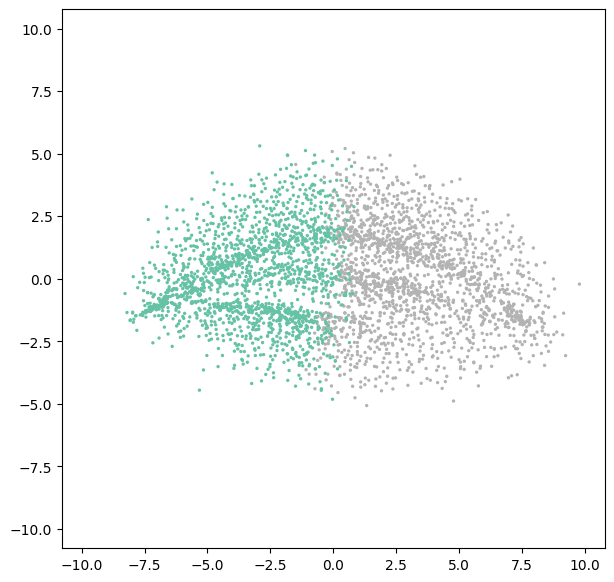

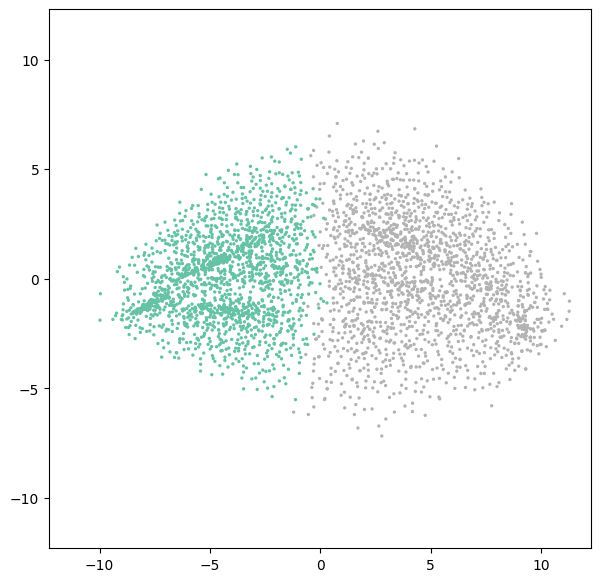

In [90]:
for ti in range(T):
    visualize_membership(z=init_z,membership=np.tile(membership,T),start=ti*N,end=(ti+1)*N)

# Step 3

In [72]:
model = ClsnaModel_2(device,N,T,ar_pair,Aw,Aw2,Ab,D=2).to(device)
with torch.no_grad():       
    model.z[:,:] = torch.from_numpy(init_z).to(device)
    model.para[:,:] = torch.from_numpy(init_para).to(device)
optimizer = torch.optim.SGD([
    {'params': model.z, "momentum": MOM, "lr": LR},
    {'params': model.para, "momentum": 0.0, "lr":LR_P}
    ])    
logL = train(optimizer)

In [73]:
delta_var = 0.1

In [74]:
def run(optimizer,index=None,fixed=None):
    for epoch in range(1,7000):
        loss = train(optimizer=optimizer,index=index,fixed=fixed)
        if epoch%1000 == 0:
            print(loss)
    return loss

In [75]:
parad = {'alpha':(0,1),'delta':(2,1),'gw':(1,1),'gw2':(3,0),'gb':(2,0)}
var_list = []
cov_list = []

for key, value in parad.items():
    model = ClsnaModel_2(device,N,T,ar_pair,Aw,Aw2,Ab,D=2).to(device)
    with torch.no_grad():       
        model.z[:,:] = torch.from_numpy(init_z).to(device)
        model.para[:,:] = torch.from_numpy(init_para).to(device)
    optimizer = torch.optim.SGD([
    {'params': model.z, "momentum": MOM, "lr": LR},
    {'params': model.para, "momentum": 0.0, "lr":LR_P}
    ])
    newlogL=run(optimizer,value,init_para[value[0],value[1]]+delta_var)
    var_hat = delta_var/(newlogL-logL)**0.5/2**0.5
    var_list.append(round(var_hat,5))
    
    diff = model.para-torch.from_numpy(init_para).to(device)
    extracted_values = [diff[value[0], value[1]].item() for value in parad.values()]
    extracted_values = np.array(extracted_values)
    cov_list.append(extracted_values/delta_var*var_hat**2)

634591.9045825191
634589.6326302757
634591.9844484926
634592.4742202937
634588.2405079905
634590.8397426357
634416.9780449085
634422.822229995
634420.1771118717
634422.0984012386
634420.8383187487
634423.3357731121
634401.9919597554
634404.8267033156
634404.3182946068
634404.6042656351
634402.6515692743
634407.4105452076
634402.2162909482
634401.6197474955
634408.4119580331
634409.5929829946
634411.6159353317
634403.5104500201
634499.633824027
634496.3585120436
634497.9426282608
634494.8783528237
634496.1933141032
634500.1829203205


In [76]:
(np.array(cov_list)*10000).round(2)

array([[ 0.25, -0.13,  0.  , -0.01,  0.01],
       [-0.12,  1.41, -0.05, -0.05, -0.02],
       [-0.01, -0.04,  2.98, -0.01, -0.1 ],
       [-0.02, -0.02, -0.02,  3.52, -0.05],
       [ 0.01, -0.03, -0.19, -0.07,  0.47]])

In [77]:
cov_m = np.array(cov_list)

In [78]:
#gammaw1-gammaw2
(cov_m[2,2]+cov_m[3,3]-cov_m[2,3]-cov_m[3,2])**0.5

0.025573275524747627

In [79]:
#gammaw1-gammab
(cov_m[2,2]+cov_m[4,4]-cov_m[2,4]-cov_m[4,2])**0.5

0.01936538490610496

In [80]:
#gammaw2-gammab
(cov_m[3,3]+cov_m[4,4]-cov_m[3,4]-cov_m[4,3])**0.5

0.02027653271139219

In [81]:
#gammaw1+gammab
(cov_m[2,2]+cov_m[4,4]+cov_m[2,4]+cov_m[4,2])**0.5

0.01775737770289257

In [82]:
#gammaw2+gammab
(cov_m[3,3]+cov_m[4,4]+cov_m[3,4]+cov_m[4,3])**0.5

0.019672570605414712

In [83]:
init_para = init_para.round(3)
printdict = {'a':init_para[0,1],'d':init_para[2,1],'gw':init_para[1,1],'gw2':init_para[3,0],'gb':init_para[2,0]}

In [84]:
cov_list

[array([ 2.52397719e-05, -1.29990868e-05,  3.78591614e-07, -1.13577484e-06,
         1.38816925e-06]),
 array([-1.19519280e-05,  1.40621143e-04, -4.92167548e-06, -4.92167548e-06,
        -2.10928949e-06]),
 array([-1.49198223e-06, -4.47648031e-06,  2.98418080e-04, -1.49207117e-06,
        -1.04444982e-05]),
 array([-1.76147587e-06, -1.76168587e-06, -1.76158087e-06,  3.52320689e-04,
        -5.28474261e-06]),
 array([ 7.01247476e-07, -2.57154728e-06, -1.94023367e-05, -6.77912968e-06,
         4.67532176e-05])]

In [85]:
# for i in range(T-1):
#     d1=zz[N*i:N*(i+1)]
#     d2=zz[N*(i+1):N*(i+2)]
#     c1=d1-(d1.mean(axis=0))[np.newaxis,:]
#     c2=d2-(d2.mean(axis=0))[np.newaxis,:]
#     R,_ = orthogonal_procrustes(c1,c2)
#     print(np.diag(R).round(2))

In [86]:
var_list

[0.00502, 0.01186, 0.01727, 0.01877, 0.00684]

In [87]:
printdict

{'a': -1.335, 'd': 0.69, 'gw': -0.148, 'gw2': 0.271, 'gb': -0.338}

In [88]:
# import csv
# fields=var_list
# with open('var001', 'a') as f:
#     writer = csv.writer(f)
#     writer.writerow(fields)

In [49]:
# import csv
# fields=list(printdict.values())
# with open('theta001', 'a') as f:
#     writer = csv.writer(f)
#     writer.writerow(fields)